In [12]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

# Configurar las opciones de visualización de pandas (opcional)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Función para limpiar columnas numéricas
def clean_numeric_column(column):
    column_as_str = column.astype(str).str.replace(',', '').str.replace('$', '').str.strip()
    return pd.to_numeric(column_as_str, errors='coerce')


# Cargar los conjuntos de datos
ruta_train = 'C:/Users/Marcio Pineda/Documents/Archivos Python/datasets/traincase.csv'
ruta_test = 'C:/Users/Marcio Pineda/Documents/Archivos Python/datasets/testcase.csv'
df_train = pd.read_csv(ruta_train)
df_test = pd.read_csv(ruta_test)

columns_to_clean = ['Search Engine Bid', 'Impressions', 'Avg. Cost per Click', 'Avg. Pos.', 'Clicks']
for column in columns_to_clean:
    df_train[column] = clean_numeric_column(df_train[column])
    if column != 'Clicks':  # 'Clicks' no está en df_test
        df_test[column] = clean_numeric_column(df_test[column])
        

min_positive_value = df_train[df_train['Impressions'] > 0]['Impressions'].min()
df_train['Impressions'] = df_train['Impressions'].replace(0, min_positive_value)
df_train['Impressions'], fitted_lambda = stats.boxcox(df_train['Impressions'])

df_train['set'] = 'Not Kaggle'
df_test['set'] = 'Kaggle'

# Concatenar df_train y df_test en df_full
df_full = pd.concat([df_train, df_test], ignore_index=True)

In [13]:
from sklearn.pipeline import make_pipeline


# Preparar los datos para el modelo
X = df_train[['Impressions', 'Search Engine Bid']]  # Asegúrate de que estas columnas están limpias y no contienen NaNs
y = df_train['Clicks'].astype(float) 

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Entrenar un modelo Lasso
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Calcular el error cuadrático medio para ambos modelos
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

rmse_ridge = sqrt(mse_ridge)
rmse_lasso = sqrt(mse_lasso)

print(f"RMSE Ridge: {rmse_ridge}, RMSE Lasso: {rmse_lasso}")

RMSE Ridge: 902.5467118401502, RMSE Lasso: 902.4850906916591


In [6]:
# Definir el modelo y los parámetros para RandomizedSearchCV
rf = RandomForestRegressor()
param_dist_rf = {'n_estimators': randint(100, 200),
                 'max_depth': [3, 5, 10, None],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_split': randint(2, 11),
                 'min_samples_leaf': randint(1, 11),
                 'bootstrap': [True, False]}

# Ejecutar RandomizedSearchCV
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=10, cv=5, scoring='neg_mean_squared_error')
random_search_rf.fit(X, y)

# Mejores parámetros y puntuación
print("Mejores parámetros para Random Forest: ", random_search_rf.best_params_)
print("Mejor puntuación (RMSE) para Random Forest: ", np.sqrt(-random_search_rf.best_score_))

# Validación cruzada para evaluar el modelo
cross_val_scores_rf = cross_val_score(random_search_rf.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error')
print("Validación cruzada (RMSE) para Random Forest: ", np.sqrt(-cross_val_scores_rf.mean()))



C:\Users\Marcio Pineda\Documents\Python\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Marcio Pineda\Documents\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Marcio Pineda\Documents\Python\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Marcio Pineda\Documents\Python\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_cons

Mejores parámetros para Random Forest:  {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 189}
Mejor puntuación (RMSE) para Random Forest:  752.3857263446581
Validación cruzada (RMSE) para Random Forest:  751.4145902193034


In [7]:
from sklearn.ensemble import GradientBoostingRegressor

# Definir el modelo y los parámetros para RandomizedSearchCV
gb = GradientBoostingRegressor()
param_dist_gb = {'n_estimators': randint(100, 200),
                 'max_depth': [3, 5, 7, 9],
                 'learning_rate': [0.01, 0.1, 0.2],
                 'subsample': [0.8, 0.9, 1.0]}

# Ejecutar RandomizedSearchCV
random_search_gb = RandomizedSearchCV(gb, param_distributions=param_dist_gb, n_iter=10, cv=5, scoring='neg_mean_squared_error')
random_search_gb.fit(X, y)

# Mejores parámetros y puntuación
print("Mejores parámetros para Gradient Boosting: ", random_search_gb.best_params_)
print("Mejor puntuación (RMSE) para Gradient Boosting: ", np.sqrt(-random_search_gb.best_score_))

# Validación cruzada para evaluar el modelo
cross_val_scores_gb = cross_val_score(random_search_gb.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error')
print("Validación cruzada (RMSE) para Gradient Boosting: ", np.sqrt(-cross_val_scores_gb.mean()))


Mejores parámetros para Gradient Boosting:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 136, 'subsample': 0.8}
Mejor puntuación (RMSE) para Gradient Boosting:  727.7540131881327
Validación cruzada (RMSE) para Gradient Boosting:  739.5802119511067


In [9]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Definir el modelo y los parámetros para RandomizedSearchCV
svr = make_pipeline(StandardScaler(), SVR())
param_dist_svr = {'svr__C': [0.1, 1, 10],
                  'svr__gamma': ['scale', 'auto'],
                  'svr__kernel': ['linear', 'rbf']}

# Ejecutar RandomizedSearchCV
random_search_svr = RandomizedSearchCV(svr, param_distributions=param_dist_svr, n_iter=10, cv=5, scoring='neg_mean_squared_error')
random_search_svr.fit(X, y)

# Mejores parámetros y puntuación
print("Mejores parámetros para SVR: ", random_search_svr.best_params_)
print("Mejor puntuación (RMSE) para SVR: ", np.sqrt(-random_search_svr.best_score_))

# Validación cruzada para evaluar el modelo
cross_val_scores_svr = cross_val_score(random_search_svr.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error')
print("Validación cruzada (RMSE) para SVR: ", np.sqrt(-cross_val_scores_svr.mean()))



Mejores parámetros para SVR:  {'svr__kernel': 'rbf', 'svr__gamma': 'scale', 'svr__C': 10}
Mejor puntuación (RMSE) para SVR:  1017.7893881304573
Validación cruzada (RMSE) para SVR:  1017.7893881304573


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Entrenar el modelo de Random Forest con los mejores parámetros
rf_best = RandomForestRegressor(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=7, n_estimators=189)
rf_best.fit(X_train, y_train)

# Entrenar el modelo de Gradient Boosting con los mejores parámetros
gb_best = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=136, subsample=0.8)
gb_best.fit(X_train, y_train)

# Evaluar el rendimiento en el conjunto de entrenamiento y validación/test
y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)  # Suponiendo que X_test es un conjunto de validación adecuado

y_train_pred_gb = gb_best.predict(X_train)
y_test_pred_gb = gb_best.predict(X_test)

print("RMSE en entrenamiento para Random Forest: ", np.sqrt(mean_squared_error(y_train, y_train_pred_rf)))
print("RMSE en entrenamiento para Gradient Boosting: ", np.sqrt(mean_squared_error(y_train, y_train_pred_gb)))

# Preparar predicciones para el conjunto de Kaggle
predictions_rf = rf_best.predict(X_test)
predictions_gb = gb_best.predict(X_test)

RMSE en entrenamiento para Random Forest:  298.68379186185786
RMSE en entrenamiento para Gradient Boosting:  119.23321057173884


In [15]:
# RMSE de entrenamiento
rmse_train_rf = 298.68379186185786
rmse_train_gb = 119.23321057173884

# RMSE de validación cruzada
rmse_cv_rf = 751.4145902193034
rmse_cv_gb = 739.5802119511067

# Comparación de RMSE de entrenamiento vs validación cruzada para Random Forest
print("Random Forest:")
print(f"RMSE de Entrenamiento: {rmse_train_rf}")
print(f"RMSE de Validación Cruzada: {rmse_cv_rf}")
print(f"Diferencia: {rmse_cv_rf - rmse_train_rf}\n")

# Comparación de RMSE de entrenamiento vs validación cruzada para Gradient Boosting
print("Gradient Boosting:")
print(f"RMSE de Entrenamiento: {rmse_train_gb}")
print(f"RMSE de Validación Cruzada: {rmse_cv_gb}")
print(f"Diferencia: {rmse_cv_gb - rmse_train_gb}\n")


Random Forest:
RMSE de Entrenamiento: 298.68379186185786
RMSE de Validación Cruzada: 751.4145902193034
Diferencia: 452.7307983574455

Gradient Boosting:
RMSE de Entrenamiento: 119.23321057173884
RMSE de Validación Cruzada: 739.5802119511067
Diferencia: 620.3470013793678



In [16]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Define los modelos base
estimators = [
    ('random_forest', RandomForestRegressor(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=7, n_estimators=189)),
    ('gradient_boosting', GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=136, subsample=0.8))
]

# Define el meta-modelo
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Entrenar el modelo de Stacking
stacking_regressor.fit(X_train, y_train)

# Evaluar el rendimiento usando validación cruzada
stacking_scores = cross_val_score(stacking_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("RMSE para Stacking: ", np.sqrt(-stacking_scores.mean()))


RMSE para Stacking:  962.6198123388475


In [18]:
from sklearn.model_selection import GridSearchCV

# Ajuste fino de Random Forest
rf = RandomForestRegressor()
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Ajuste fino de Gradient Boosting
gb = GradientBoostingRegressor()
param_grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definición de hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Inicialización y ajuste fino de Random Forest
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

print(f"Mejores hiperparámetros para Random Forest: {grid_search_rf.best_params_}")


from sklearn.ensemble import GradientBoostingRegressor

# Definición de hiperparámetros para Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Inicialización y ajuste fino de Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_gb.fit(X_train, y_train)

print(f"Mejores hiperparámetros para Gradient Boosting: {grid_search_gb.best_params_}")


# Predicciones en entrenamiento y prueba para Random Forest
y_train_pred_rf = grid_search_rf.best_estimator_.predict(X_train)
y_test_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

# Predicciones en entrenamiento y prueba para Gradient Boosting
y_train_pred_gb = grid_search_gb.best_estimator_.predict(X_train)
y_test_pred_gb = grid_search_gb.best_estimator_.predict(X_test)

# Cálculo de RMSE para entrenamiento y prueba
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

rmse_train_gb = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
rmse_test_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))

print(f"Random Forest RMSE - Entrenamiento: {rmse_train_rf}, Prueba: {rmse_test_rf}")
print(f"Gradient Boosting RMSE - Entrenamiento: {rmse_train_gb}, Prueba: {rmse_test_gb}")








Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros para Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros para Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9}
Random Forest RMSE - Entrenamiento: 275.92059323042946, Prueba: 1180.1635738338193
Gradient Boosting RMSE - Entrenamiento: 431.0597038276074, Prueba: 1045.0408916773213


In [25]:
rf_reg_ajustado = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,  # Profundidad máxima reducida
    min_samples_split=5,  # Aumenta para más regularización
    min_samples_leaf=4,  # Aumenta para más regularización
    bootstrap=True,
    random_state=42
)

rf_reg_ajustado.fit(X_train, y_train)

# Evaluar el rendimiento
y_pred_train_rf_ajustado = rf_reg_ajustado.predict(X_train)
y_pred_test_rf_ajustado = rf_reg_ajustado.predict(X_test)

print("Random Forest Ajustado RMSE - Entrenamiento:", np.sqrt(mean_squared_error(y_train, y_pred_train_rf_ajustado)))
print("Random Forest Ajustado RMSE - Prueba:", np.sqrt(mean_squared_error(y_test, y_pred_test_rf_ajustado)))



Random Forest Ajustado RMSE - Entrenamiento: 726.3333815400237
Random Forest Ajustado RMSE - Prueba: 796.457469440564


In [26]:
gb_reg_ajustado = GradientBoostingRegressor(
    n_estimators=500,  # Aumenta el número de estimadores
    learning_rate=0.01,  # Disminuye la tasa de aprendizaje
    max_depth=5,  # Control más estricto sobre la profundidad
    subsample=0.8,  # Muestreo de las observaciones
    random_state=42
)

gb_reg_ajustado.fit(X_train, y_train)

# Evaluar el rendimiento
y_pred_train_gb_ajustado = gb_reg_ajustado.predict(X_train)
y_pred_test_gb_ajustado = gb_reg_ajustado.predict(X_test)

print("Gradient Boosting Ajustado RMSE - Entrenamiento:", np.sqrt(mean_squared_error(y_train, y_pred_train_gb_ajustado)))
print("Gradient Boosting Ajustado RMSE - Prueba:", np.sqrt(mean_squared_error(y_test, y_pred_test_gb_ajustado)))



Gradient Boosting Ajustado RMSE - Entrenamiento: 142.1976602272278
Gradient Boosting Ajustado RMSE - Prueba: 1351.7415332451665


In [28]:
# Instala XGBoost
!pip install xgboost

import xgboost as xgb

# Configuración del modelo XGBoost
xgb_reg = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,  # Regularización L1
    reg_lambda=1,  # Regularización L2
    random_state=42
)

xgb_reg.fit(X_train, y_train)

# Evaluar el rendimiento
y_pred_train_xgb = xgb_reg.predict(X_train)
y_pred_test_xgb = xgb_reg.predict(X_test)

print("XGBoost RMSE - Entrenamiento:", np.sqrt(mean_squared_error(y_train, y_pred_train_xgb)))
print("XGBoost RMSE - Prueba:", np.sqrt(mean_squared_error(y_test, y_pred_test_xgb)))


   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 1.3 MB/s eta 0:01:18
   ---------------------------------------- 0.2/99.8 MB 3.6 MB/s eta 0:00:28
   ---------------------------------------- 0.6/99.8 MB 5.1 MB/s eta 0:00:20
   ---------------------------------------- 1.0/99.8 MB 6.4 MB/s eta 0:00:16
    --------------------------------------- 1.3/99.8 MB 6.3 MB/s eta 0:00:16
    --------------------------------------- 1.7/99.8 MB 6.8 MB/s eta 0:00:15
    --------------------------------------- 2.1/99.8 MB 6.9 MB/s eta 0:00:15
    --------------------------------------- 2.4/99.8 MB 7.0 MB/s eta 0:00:14
   - -------------------------------------- 2.7/99.8 MB 6.9 MB/s eta 0:00:14
   - -------------------------------------- 3.0/99.8 MB 6.8 MB/s eta 0:00:15
   - -------------------------------------- 3.2/99.8 MB 6.5 MB/s eta 0:00:15
   - -------------------------------------- 3.4/99.8 MB 6.3 MB/s eta 0:00:16
   - -

XGBoost RMSE - Entrenamiento: 438.19476990203776
XGBoost RMSE - Prueba: 1206.3420500768923


In [29]:
# Instala LightGBM
!pip install lightgbm

import lightgbm as lgb

# Configuración del modelo LightGBM
lgb_reg = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # Regularización L1
    reg_lambda=1,  # Regularización L2
    random_state=42
)

lgb_reg.fit(X_train, y_train)

# Evaluar el rendimiento
y_pred_train_lgb = lgb_reg.predict(X_train)
y_pred_test_lgb = lgb_reg.predict(X_test)

print("LightGBM RMSE - Entrenamiento:", np.sqrt(mean_squared_error(y_train, y_pred_train_lgb)))
print("LightGBM RMSE - Prueba:", np.sqrt(mean_squared_error(y_test, y_pred_test_lgb)))



   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB 1.3 MB/s eta 0:00:02
   --------- ------------------------------ 0.3/1.3 MB 3.8 MB/s eta 0:00:01
   --------------------- ------------------ 0.7/1.3 MB 5.7 MB/s eta 0:00:01
   ----------------------------------- ---- 1.2/1.3 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 6.1 MB/s eta 0:00:00
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [30]:
# Función para limpiar y convertir "Impressions" a formato numérico
def clean_and_convert(column):
    column = pd.to_numeric(column, errors='coerce')  # Convierte a numérico, 'coerce' convierte errores a NaN
    return column

# Aplicar la limpieza y conversión
df_train['Impressions'] = clean_and_convert(df_train['Impressions'])
df_test['Impressions'] = clean_and_convert(df_test['Impressions'])

# Imputar los valores faltantes después de la conversión, si los hay, usando la mediana de las impresiones
df_train['Impressions'].fillna(df_train['Impressions'].median(), inplace=True)
df_test['Impressions'].fillna(df_test['Impressions'].median(), inplace=True)


In [31]:
import numpy as np

df_train['Impressions_log'] = np.log1p(df_train['Impressions'])  # log1p para manejar ceros, sumando 1 antes del logaritmo
df_test['Impressions_log'] = np.log1p(df_test['Impressions'])


In [32]:
from scipy import stats

# La transformación Box-Cox requiere que todos los valores sean positivos
df_train['Impressions'] += 1  # Asegurarse de que no hay valores cero
df_test['Impressions'] += 1

# Aplicar transformación Box-Cox
df_train['Impressions_boxcox'], fitted_lambda = stats.boxcox(df_train['Impressions'])
df_test['Impressions_boxcox'] = stats.boxcox(df_test['Impressions'], lmbda=fitted_lambda)


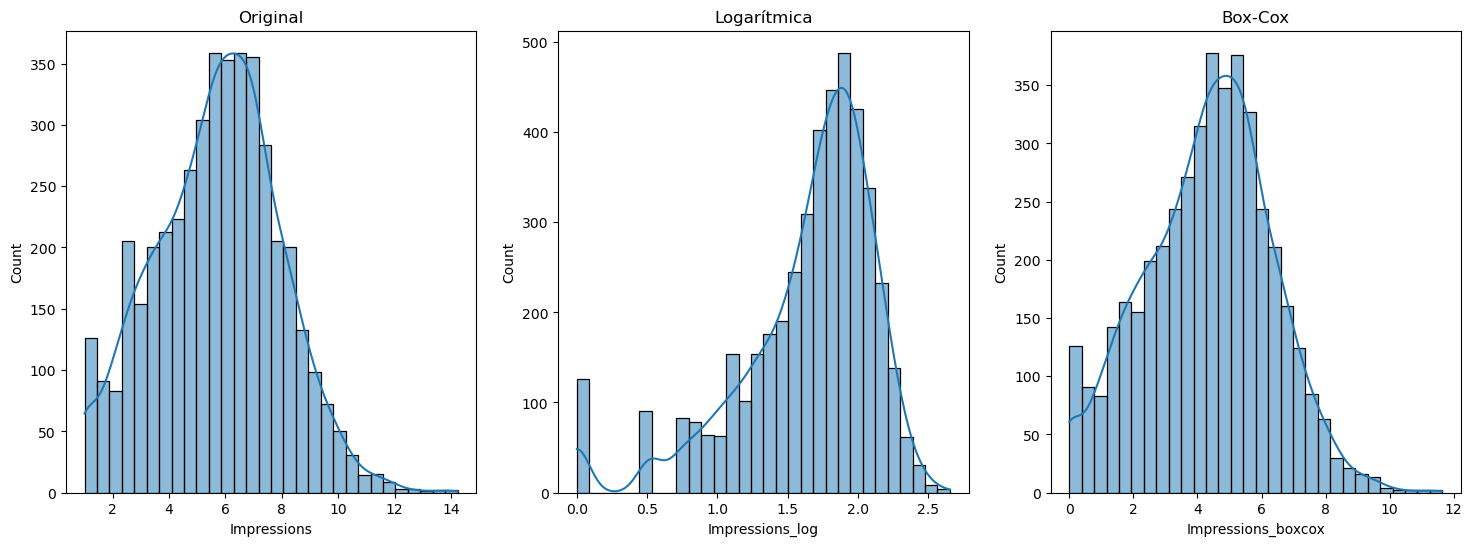

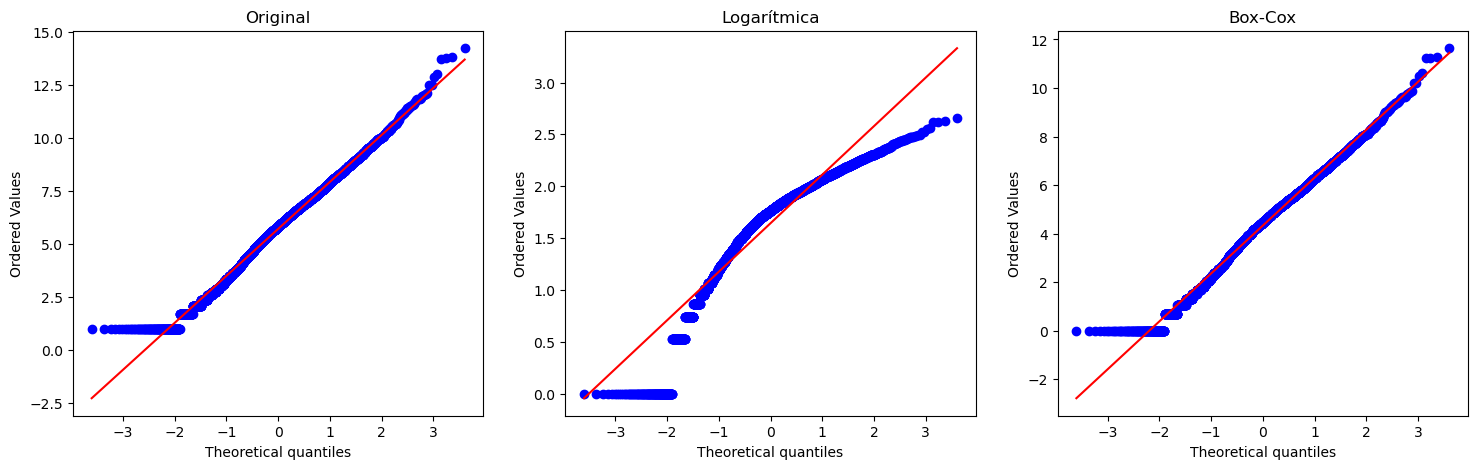

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

# Histogramas
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.histplot(df_train['Impressions'], kde=True, bins=30)
plt.title('Original')
plt.subplot(1, 3, 2)
sns.histplot(df_train['Impressions_log'], kde=True, bins=30)
plt.title('Logarítmica')
plt.subplot(1, 3, 3)
sns.histplot(df_train['Impressions_boxcox'], kde=True, bins=30)
plt.title('Box-Cox')
plt.show()

# Gráficos Q-Q
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
probplot(df_train['Impressions'], dist="norm", plot=plt)
plt.title('Original')
plt.subplot(1, 3, 2)
probplot(df_train['Impressions_log'], dist="norm", plot=plt)
plt.title('Logarítmica')
plt.subplot(1, 3, 3)
probplot(df_train['Impressions_boxcox'], dist="norm", plot=plt)
plt.title('Box-Cox')
plt.show()


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definir el espacio de búsqueda de hiperparámetros para Random Forest
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Configurar RandomizedSearchCV
random_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist_rf, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)

# Mejores hiperparámetros encontrados para Random Forest
print("Mejores hiperparámetros para Random Forest:", random_search_rf.best_params_)


Mejores hiperparámetros para Random Forest: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 355}
